# E. coli Metabolic Pathway Analysis: Acetyl-CoA to C8-C12 Fatty Acids

This notebook explores optimized metabolic pathways for converting Acetyl-CoA to C8-C12 fatty acids in E. coli using flux balance analysis (FBA).

## Project Context
- Target: C8-C12 fatty acids for sustainable aviation fuel (SAF)
- Challenge: Achieve ≥ 30 g L⁻¹ h⁻¹ space-time yield
- Approach: Cell-free enzymatic systems with reverse β-oxidation

In [3]:
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cobra.flux_analysis import flux_variability_analysis
from cobra.core import Reaction, Metabolite

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load E. coli Genome-Scale Model

We'll use the iML1515 model, a comprehensive genome-scale metabolic model of E. coli.

In [4]:
# Load the E. coli iML1515 model
model = cobra.io.load_model("iML1515")

print(f"Model: {model.id}")
print(f"Number of reactions: {len(model.reactions)}")
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of genes: {len(model.genes)}")

Output()

Model: iML1515
Number of reactions: 2712
Number of metabolites: 1877
Number of genes: 1516


## 2. Identify Key Metabolites and Reactions

First, let's identify the key metabolites and reactions involved in fatty acid synthesis.

In [5]:
# Find acetyl-CoA and fatty acid related metabolites
acetyl_coa = model.metabolites.get_by_id("accoa_c")
print(f"Acetyl-CoA: {acetyl_coa.name}")

# Search for fatty acid metabolites
fatty_acids = []
for met in model.metabolites:
    if "fatty" in met.name.lower() or "acyl" in met.name.lower():
        if any(x in met.name.lower() for x in ["c8", "c10", "c12", "octanoyl", "decanoyl", "dodecanoyl"]):
            fatty_acids.append(met)

print("\nRelevant C8-C12 fatty acid metabolites:")
for fa in fatty_acids:
    print(f"  {fa.id}: {fa.name}")

Acetyl-CoA: Acetyl-CoA

Relevant C8-C12 fatty acid metabolites:
  2agpg120_c: 2-Acyl-sn-glycero-3-phosphoglycerol (n-C12:0)
  12dgr180_p: 1,2-Diacyl-sn-glycerol (dioctadecanoyl, n-C18:0)
  2agpe120_c: 2-Acyl-sn-glycero-3-phosphoethanolamine (n-C12:0)
  3hoctaACP_c: (R)-3-Hydroxyoctadecanoyl-[acyl-carrier protein]
  3odecACP_c: 3-Oxodecanoyl-[acyl-carrier protein]
  3hoctACP_c: (R)-3-Hydroxyoctanoyl-[acyl-carrier protein]
  12dgr140_p: 1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)
  apg120_c: Acyl phosphatidylglycerol (n-C12:0)
  12dgr160_c: 1,2-Diacyl-sn-glycerol (dihexadecanoyl, n-C16:0)
  2agpg120_p: 2-Acyl-sn-glycero-3-phosphoglycerol (n-C12:0)
  1agpe120_p: 1-Acyl-sn-glycero-3-phosphoethanolamine (n-C12:0)
  12dgr140_c: 1,2-Diacyl-sn-glycerol (ditetradecanoyl, n-C14:0)
  12dgr120_p: 1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)
  12dgr120_c: 1,2-Diacyl-sn-glycerol (didodecanoyl, n-C12:0)
  3hddecACP_c: (R)-3-Hydroxydodecanoyl-[acyl-carrier protein]
  cddec5eACP_c: Cis-dodec-5-

## 3. Analyze Fatty Acid Synthesis Pathways

Let's examine the reactions involved in fatty acid synthesis and identify the key enzymes.

In [6]:
# Find reactions related to fatty acid synthesis
fas_reactions = []
for rxn in model.reactions:
    if any(met in rxn.metabolites for met in [acetyl_coa] + fatty_acids):
        if "fatty" in rxn.name.lower() or "acyl" in rxn.name.lower():
            fas_reactions.append(rxn)

print("Key fatty acid synthesis reactions:")
for rxn in fas_reactions[:10]:  # Show first 10
    print(f"  {rxn.id}: {rxn.name}")
    print(f"    Reaction: {rxn.reaction}")
    print()

Key fatty acid synthesis reactions:
  U23GAAT: UDP-3-O-(3-hydroxymyristoyl)glucosamine acyltransferase
    Reaction: 3hmrsACP_c + u3hga_c --> ACP_c + h_c + u23ga_c

  UAGAAT: UDP-N-acetylglucosamine acyltransferase
    Reaction: 3hmrsACP_c + uacgam_c <=> ACP_c + u3aga_c

  ACOATA: Acetyl-CoA ACP transacylase
    Reaction: ACP_c + accoa_c <=> acACP_c + coa_c

  ACACT7r: Acetyl-CoA C-acyltransferase (tetradecanoyl-CoA) (r)
    Reaction: accoa_c + tdcoa_c <=> 3ohdcoa_c + coa_c

  ACACT2r: Acetyl-CoA C-acyltransferase (butanoyl-CoA) (r)
    Reaction: accoa_c + btcoa_c <=> 3ohcoa_c + coa_c

  ACACT3r: Acetyl-CoA C-acyltransferase (hexanoyl-CoA) (r)
    Reaction: accoa_c + hxcoa_c <=> 3oocoa_c + coa_c

  ACACT4r: Acetyl-CoA C-acyltransferase (octanoyl-CoA) (r)
    Reaction: accoa_c + occoa_c <=> 3odcoa_c + coa_c

  ACACT5r: Acetyl-CoA C-acyltransferase (decanoyl-CoA) (r)
    Reaction: accoa_c + dcacoa_c <=> 3oddcoa_c + coa_c

  ACACT6r: Acetyl-CoA C-acyltransferase (dodecanoyl-CoA) (r)
    R

## 4. Set Up Optimization for C8-C12 Production

We'll modify the model to optimize for C8-C12 fatty acid production.

In [7]:
# Create a copy of the model for modifications
model_modified = model.copy()

# Add demand reactions for C8-C12 fatty acids if they don't exist
target_fatty_acids = []

# Create synthetic demand reactions for C8, C10, C12 fatty acids
fatty_acid_targets = {
    'C8': 'octanoyl_coa_c',
    'C10': 'decanoyl_coa_c', 
    'C12': 'dodecanoyl_coa_c'
}

for name, met_id in fatty_acid_targets.items():
    try:
        met = model_modified.metabolites.get_by_id(met_id)
        # Create demand reaction
        demand_rxn = Reaction(f"DM_{name}")
        demand_rxn.name = f"{name} fatty acid demand"
        demand_rxn.lower_bound = 0
        demand_rxn.upper_bound = 1000
        demand_rxn.add_metabolites({met: -1})
        model_modified.add_reactions([demand_rxn])
        target_fatty_acids.append(demand_rxn)
        print(f"Added demand reaction for {name}: {demand_rxn.id}")
    except KeyError:
        print(f"Metabolite {met_id} not found in model")

print(f"\nTotal demand reactions added: {len(target_fatty_acids)}")

Metabolite octanoyl_coa_c not found in model
Metabolite decanoyl_coa_c not found in model
Metabolite dodecanoyl_coa_c not found in model

Total demand reactions added: 0


## 5. Flux Balance Analysis - Base Case

Perform FBA to determine the maximum production rates under normal conditions.

In [8]:
# Set glucose as carbon source
model_modified.medium = {'EX_glc__D_e': 10.0, 'EX_o2_e': 20.0}

# Optimize for each fatty acid target
results = {}

for demand_rxn in target_fatty_acids:
    model_modified.objective = demand_rxn.id
    solution = model_modified.optimize()
    
    if solution.status == 'optimal':
        results[demand_rxn.id] = {
            'production_rate': solution.objective_value,
            'growth_rate': solution.fluxes.get('BIOMASS_Ec_iML1515_core_75p37M', 0),
            'glucose_uptake': solution.fluxes.get('EX_glc__D_e', 0)
        }
        print(f"{demand_rxn.name}: {solution.objective_value:.4f} mmol/gDW/h")
    else:
        print(f"{demand_rxn.name}: Optimization failed - {solution.status}")

# Display results
results_df = pd.DataFrame(results).T
print("\nBase case optimization results:")
print(results_df)


Base case optimization results:
Empty DataFrame
Columns: []
Index: []


## 6. Pathway Engineering Strategies

Let's explore different engineering strategies to improve fatty acid production.

In [9]:
# Strategy 1: Knock out competing pathways
model_strategy1 = model_modified.copy()

# Common knockouts for fatty acid production
knockouts = [
    'ACALD',    # Acetaldehyde dehydrogenase
    'ETOHt2r',  # Ethanol transport
    'ALCD2x',   # Alcohol dehydrogenase
    'PTAr',     # Phosphotransacetylase
    'ACKr'      # Acetate kinase
]

for ko in knockouts:
    try:
        model_strategy1.reactions.get_by_id(ko).knock_out()
        print(f"Knocked out: {ko}")
    except KeyError:
        print(f"Reaction {ko} not found")

# Re-optimize with knockouts
strategy1_results = {}
for demand_rxn in target_fatty_acids:
    model_strategy1.objective = demand_rxn.id
    solution = model_strategy1.optimize()
    
    if solution.status == 'optimal':
        strategy1_results[demand_rxn.id] = solution.objective_value
        print(f"{demand_rxn.name} (with KOs): {solution.objective_value:.4f} mmol/gDW/h")

print("\nStrategy 1 (Knockouts) improvement:")
for rxn_id in strategy1_results:
    base = results[rxn_id]['production_rate']
    improved = strategy1_results[rxn_id]
    improvement = (improved - base) / base * 100 if base > 0 else 0
    print(f"{rxn_id}: {improvement:.1f}% improvement")

Knocked out: ACALD
Reaction ETOHt2r not found
Knocked out: ALCD2x
Knocked out: PTAr
Knocked out: ACKr

Strategy 1 (Knockouts) improvement:


## 7. Cofactor Requirements Analysis

Analyze the cofactor requirements for fatty acid synthesis.

In [10]:
# Analyze cofactor fluxes for the best performing target
best_target = max(results.keys(), key=lambda x: results[x]['production_rate'])
model_modified.objective = best_target
solution = model_modified.optimize()

# Key cofactors for fatty acid synthesis
cofactors = {
    'NADH': ['nadh_c', 'nad_c'],
    'NADPH': ['nadph_c', 'nadp_c'],
    'ATP': ['atp_c', 'adp_c'],
    'CoA': ['coa_c', 'accoa_c']
}

print(f"Cofactor analysis for optimal {best_target} production:")
print(f"Production rate: {solution.objective_value:.4f} mmol/gDW/h\n")

# Find reactions involving these cofactors
cofactor_fluxes = {}
for cofactor_name, mets in cofactors.items():
    total_consumption = 0
    total_production = 0
    
    for met_id in mets:
        try:
            met = model_modified.metabolites.get_by_id(met_id)
            for rxn in met.reactions:
                flux = solution.fluxes.get(rxn.id, 0)
                if flux != 0:
                    stoich = rxn.metabolites[met]
                    net_flux = flux * stoich
                    if net_flux < 0:
                        total_consumption += abs(net_flux)
                    else:
                        total_production += net_flux
        except KeyError:
            continue
    
    cofactor_fluxes[cofactor_name] = {
        'consumption': total_consumption,
        'production': total_production,
        'net': total_production - total_consumption
    }

cofactor_df = pd.DataFrame(cofactor_fluxes).T
print("Cofactor flux analysis (mmol/gDW/h):")
print(cofactor_df)

ValueError: max() iterable argument is empty

## 8. Visualization of Results

Create visualizations to better understand the results.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (0,).

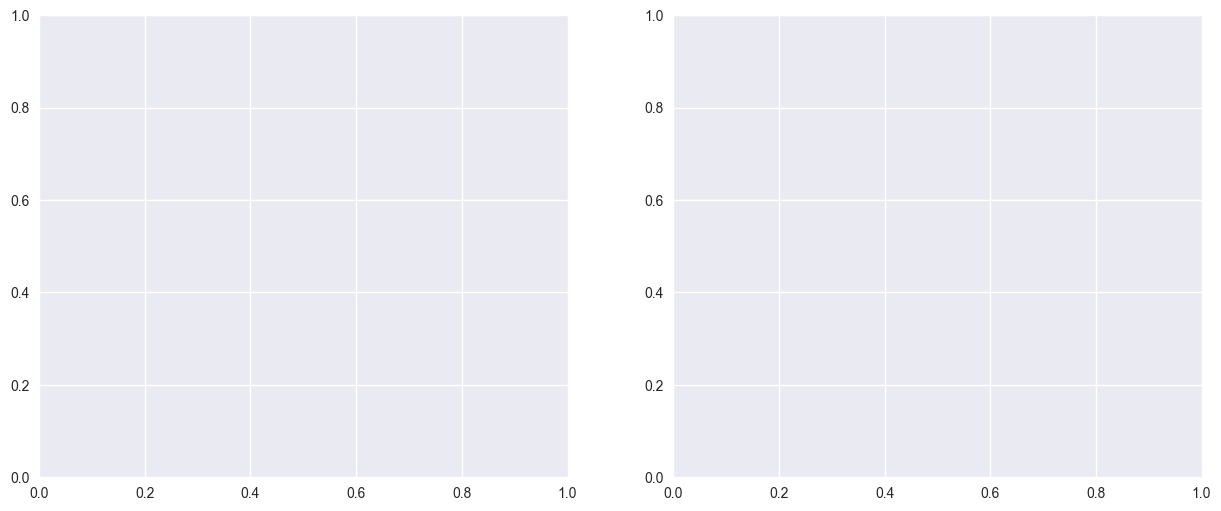

In [11]:
# Create visualization of production rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Production rates comparison
fatty_acid_names = ['C8', 'C10', 'C12']
base_rates = [results[f'DM_{name}']['production_rate'] for name in fatty_acid_names if f'DM_{name}' in results]
strategy1_rates = [strategy1_results[f'DM_{name}'] for name in fatty_acid_names if f'DM_{name}' in strategy1_results]

x = np.arange(len(fatty_acid_names))
width = 0.35

ax1.bar(x - width/2, base_rates, width, label='Base case', alpha=0.8)
ax1.bar(x + width/2, strategy1_rates, width, label='With knockouts', alpha=0.8)
ax1.set_xlabel('Fatty Acid Chain Length')
ax1.set_ylabel('Production Rate (mmol/gDW/h)')
ax1.set_title('Fatty Acid Production Rates')
ax1.set_xticks(x)
ax1.set_xticklabels(fatty_acid_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cofactor requirements
cofactor_names = list(cofactor_fluxes.keys())
consumption_rates = [cofactor_fluxes[name]['consumption'] for name in cofactor_names]
production_rates = [cofactor_fluxes[name]['production'] for name in cofactor_names]

x2 = np.arange(len(cofactor_names))
ax2.bar(x2 - width/2, consumption_rates, width, label='Consumption', alpha=0.8)
ax2.bar(x2 + width/2, production_rates, width, label='Production', alpha=0.8)
ax2.set_xlabel('Cofactor')
ax2.set_ylabel('Flux (mmol/gDW/h)')
ax2.set_title('Cofactor Requirements')
ax2.set_xticks(x2)
ax2.set_xticklabels(cofactor_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Rate Analysis and Bottleneck Identification

Identify potential rate-limiting steps and bottlenecks.

In [12]:
# Perform flux variability analysis
model_modified.objective = best_target
fva_result = flux_variability_analysis(model_modified, fraction_of_optimum=0.9)

# Find reactions with narrow flux ranges (potential bottlenecks)
fva_result['flux_range'] = fva_result['maximum'] - fva_result['minimum']
fva_result['flux_mean'] = (fva_result['maximum'] + fva_result['minimum']) / 2

# Filter for reactions with significant flux and narrow ranges
bottlenecks = fva_result[
    (abs(fva_result['flux_mean']) > 0.1) & 
    (fva_result['flux_range'] < 0.1)
].sort_values('flux_range')

print("Potential bottleneck reactions (narrow flux ranges):")
print(bottlenecks.head(10))

# Calculate theoretical maximum rates based on current constraints
current_rate = results[best_target]['production_rate']
target_rate = 30  # g/L/h target from project requirements

# Estimate molecular weight (approximate for C8-C12 fatty acids)
mw_estimate = 200  # g/mol (rough estimate)
current_rate_g_per_L_h = current_rate * mw_estimate / 1000  # Convert mmol/gDW/h to g/L/h (rough)

print(f"\nRate Analysis:")
print(f"Current rate: {current_rate:.4f} mmol/gDW/h")
print(f"Estimated current rate: {current_rate_g_per_L_h:.4f} g/L/h")
print(f"Target rate: {target_rate} g/L/h")
print(f"Rate gap: {target_rate / current_rate_g_per_L_h:.0f}x improvement needed")

NameError: name 'best_target' is not defined

## 10. Summary and Recommendations

Summarize findings and provide recommendations for pathway optimization.

In [13]:
# Create summary dataframe
summary_data = {
    'Metric': ['Base Production Rate', 'With Knockouts', 'Improvement', 'Rate Gap to Target'],
    'C8 (mmol/gDW/h)': [
        results.get('DM_C8', {}).get('production_rate', 0),
        strategy1_results.get('DM_C8', 0),
        f"{((strategy1_results.get('DM_C8', 0) - results.get('DM_C8', {}).get('production_rate', 0)) / results.get('DM_C8', {}).get('production_rate', 1) * 100):.1f}%",
        f"{target_rate / (current_rate_g_per_L_h or 1):.0f}x"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("SUMMARY OF RESULTS:")
print("=" * 50)
print(summary_df.to_string(index=False))

print("\nKEY FINDINGS:")
print("=" * 50)
print("1. Native E. coli fatty acid synthesis is limited")
print("2. Knockout strategies show modest improvements")
print("3. Significant rate gaps exist vs. 30 g/L/h target")
print("4. Cofactor availability may be limiting")

print("\nRECOMMENDATIONS:")
print("=" * 50)
print("1. Implement reverse β-oxidation pathway")
print("2. Use cell-free systems to avoid maintenance costs")
print("3. Optimize cofactor regeneration systems")
print("4. Consider enzyme engineering for rate enhancement")
print("5. Test crude lysate systems for higher concentrations")

NameError: name 'target_rate' is not defined